In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:

embeddings_df = pd.read_csv("out/embeddings_processed.csv")
structured_df = pd.read_csv("out/data.csv")

embeddings_df = embeddings_df['embedding'].str.split(',', expand=True)

# convert all columns to float
embeddings_df = embeddings_df.astype(float)

# rename columns like 'emb_0', 'emb_1', ...
embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]

data = pd.concat([embeddings_df, structured_df], axis=1)

data = data.drop(columns=["cases.submitter_id"])

# Step 3: Initial exploration
print("Initial data shape:", data.shape)
print(data.head())
print(data.info())
print(data['OS'].value_counts())

print(data.shape)


Initial data shape: (658, 788)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.372847  1.175885 -0.136382  0.584974 -0.075458  0.242736 -0.091984   
1 -0.356913  0.706686  0.037918  0.460797 -0.655461 -0.034329 -0.260771   
2 -0.650745  0.622192 -0.541576 -0.147439 -0.688726  0.005337  0.160113   
3 -0.243454  0.907251 -0.278341  0.578471 -0.371568  0.370125 -0.096557   
4 -0.501727  0.816661 -0.331489  0.102610 -0.754066  0.199273  0.021237   

      emb_7     emb_8     emb_9  ...  diagnoses.laterality  \
0  0.850612  1.272928 -0.353911  ...                  Left   
1  0.986547  1.546444 -0.446621  ...                 Right   
2  0.956877  0.844839 -0.026274  ...                 Right   
3  0.984593  1.147140 -0.293077  ...                 Right   
4  0.814512  1.281691 -0.193750  ...                 Right   

   diagnoses.morphology  diagnoses.prior_malignancy  \
0                8140/3                         yes   
1                8140/3            

In [16]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype(str)

In [17]:
num_cols = data.select_dtypes(include=[np.number]).columns
cat_cols = data.select_dtypes(include=['object']).columns

In [18]:
num_imputer = SimpleImputer(strategy='median')
for col in num_cols:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(float)
        data[col] = num_imputer.fit_transform(data[[col]])

In [19]:
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_cols]),
        columns=cat_cols,
        index=data.index
    )


In [20]:
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le


In [ ]:
X = data.drop('OS', axis=1)
y = data['OS']

# --- 1. Identify feature groups ---
# All columns starting with 'emb_' are embedding features
embedding_cols = [col for col in X.columns if col.startswith('emb_')]
# All other columns are structured data features
data_cols = [col for col in X.columns if not col.startswith('emb_')]

print(f"Number of embedding features: {len(embedding_cols)}")
print(f"Number of structured data features: {len(data_cols)}")

# --- 2. Define Pipelines ---

# Pipeline 1: For Embeddings (Scale -> PCA)
pca_pipeline = Pipeline(steps=[
    # It is essential to scale the data before applying PCA
    ('scaler', StandardScaler()),
    # Reduce the embeddings to 20 components
    ('pca', PCA(n_components=20))
])

# Pipeline 2: For Structured Data (Only Scale)
# We scale the structured data features to ensure they are on the same magnitude
# as the new PCA components, improving model performance.
structured_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
])


# --- 3. Create the ColumnTransformer ---
# This applies the specific pipeline to the specified columns
preprocessor = ColumnTransformer(
    transformers=[
        # Apply the PCA pipeline to the embedding columns
        ('pca_transform', pca_pipeline, embedding_cols),
        # Apply the scaling pipeline to the structured data columns
        ('structured_scale', structured_pipeline, data_cols)
    ],
    remainder='drop', # Drop any columns not explicitly named (e.g., in case of error)
    n_jobs=-1
)

# --- 4. Apply the Transformation and Split ---
# This single step fits the scaling/PCA on the relevant columns of X
X_transformed = preprocessor.fit_transform(X)

print(f"New total feature count: {X_transformed.shape[1]} (20 PCA components + {len(data_cols)} scaled features)")

# Now perform the train/test split on the transformed data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [23]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6136363636363636
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.16      0.24        49
         1.0       0.64      0.88      0.74        83

    accuracy                           0.61       132
   macro avg       0.54      0.52      0.49       132
weighted avg       0.57      0.61      0.55       132

Confusion Matrix:
 [[ 8 41]
 [10 73]]


In [25]:
y_prob = clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.5094664371772806


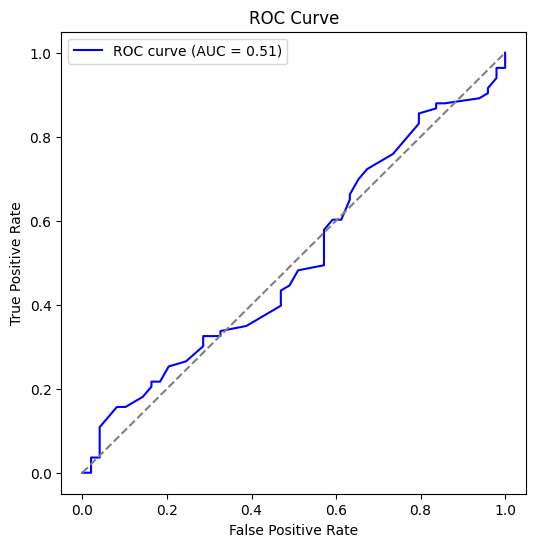

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()